# Quiescent Background
This algorithm can be used to determine the quescient background in a light curve/ time series. <br>
original reference: Meyer et al. 2019 (https://ui.adsabs.harvard.edu/abs/2019HEAD...1710672M/abstract)<br>
original code: Manuel Meyer (https://github.com/me-manu/GaRLiC)


#### Procedure:
1. sort flux (error) array and set range for QB value
2. create flux_grid within range for QB value
3. iterate through flux_grid and determine CDF of flux weights on equivalent intervals on left and right side of each grid value
4. idea: best value for QB is where the CDFs of both intervals are most similar <br> $\rightarrow$ quantify similarity with:
  * ks
  * sumsq
  * sumsqpy
  * wolpert_jeff
5. determine QB

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln 


### 0. Data
use exemplary data or insert your data here

Text(0, 0.5, 'flux')

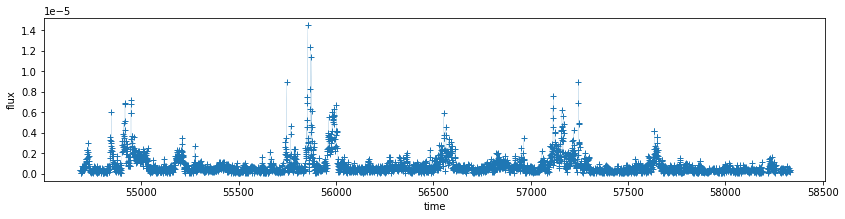

In [3]:
lc = np.load('../bsp_data/bsp_lc.npy', allow_pickle=True)
time = lc[0]
flux = lc[1]
flux_error = lc[2]

plt.figure(0,(14,3))
plt.plot(time, flux, linewidth=0.1, marker='+')
plt.xlabel('time')
plt.ylabel('flux')

### 1. sort flux (error) array and set range for QB value
value range = consider flux values between some min and the mean; this is where flux grid will be defined

In [4]:
# ------ Set Parameters ------
flux_vec = flux 
# array-like
# array of flux values

weight_vec = flux_error 
# array-like (optional)
# array with weights for fluxes (same shape as flux_vec)

fudge_factor = 0.1
# float (optional)
# factor to avoid some trouble just above the flux minimum. 
# ----------------------------

In [5]:
if weight_vec is None: 
    weight_vec = np.ones_like(flux_vec)

id_sort = np.argsort(flux_vec)
flux_vec = np.sort(flux_vec) 
weight_vec = weight_vec[id_sort]
flux_mean = flux_vec.mean() # or median
flux_min_use = flux_vec[0] + fudge_factor * ( flux_mean - flux_vec[0] ) 

Text(0, 0.5, 'counts')

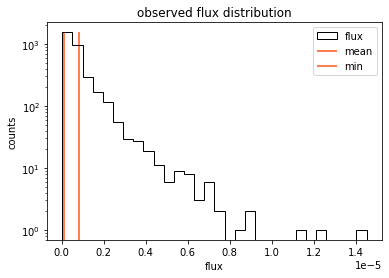

In [6]:
plt.title('observed flux distribution')
c,v,p = plt.hist(flux_vec, bins=30, log=True, histtype= 'step', color='k', label='flux')
plt.vlines(flux_mean, ymin=min(c), ymax=max(c), linewidth=2, color='coral', label='mean')
plt.vlines(flux_min_use, ymin=min(c), ymax=max(c), linewidth=2, color='coral', label='min')
plt.legend()
plt.xlabel('flux')
plt.ylabel('counts')


### 2. create flux_grid
either all values contained in range or num_grid equally spaced values

In [7]:
# ------ Set Parameters ------
num_grid = 0
# size of flux array tested for the peak of the symmetric 
# quiescent flux i.e. suspicion that qb is within that range. 
# If zero, use the measured flux values
# ----------------------------

In [8]:
if num_grid: 
    flux_grid = np.linspace(flux_min_use, flux_mean, num_grid)
else: 
    flux_grid = flux_vec[np.where(flux_vec >= flux_min_use)[0][0]:np.where(flux_vec <= flux_mean)[0][-1]]

Text(0, 0.5, 'counts')

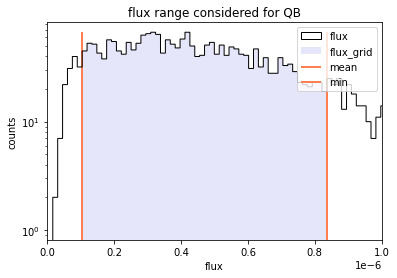

In [9]:
def plot_hist_selected(vals_all, vals_select, bins_select):
    #create two in one histogram with bins based on selected portion
    val, binz = np.histogram(vals_select, bins=bins_select)
    bin_width = binz[1] - binz[0]
    left_shift = math.ceil((vals_select[0] - vals_all[0])/bin_width)

    b = binz[0] - left_shift * bin_width
    binzz = [b]
    while b <= vals_all[-1]:
        b += bin_width
        binzz.append(b)
        
    c,v,p = plt.hist(vals_all, bins=binzz, log=True, histtype= 'step', color='k', label='flux')
    plt.hist(vals_select, bins=binz, log=True, color='lavender', label='flux_grid', zorder=0)
    plt.xlim(0,1e-6)
    return(c)

plt.title('flux range considered for QB')
if num_grid:
    c = plot_hist_selected(flux_vec, flux_grid, num_grid)
else:
    c = plot_hist_selected(flux_vec, flux_grid, 50)
plt.vlines(flux_mean, ymin=min(c), ymax=max(c), linewidth=2, color='coral', label='mean')
plt.vlines(flux_min_use, ymin=min(c), ymax=max(c), linewidth=2, color='coral', label='min')
plt.legend()
plt.xlabel('flux')
plt.ylabel('counts')


### 3. iterate through flux_grid and determine CDF (of flux weights) on left and right side of each value 
create equal, linear interval on both sides of each grid value with num_bins bins between lowest flux and grid value + lowest flux

In [10]:
# ------ Set Parameters ------
num_bins = 100
# number of bins for high and low flux arrays
# ----------------------------

In [11]:
def compute_cdf(flux_grid, f_indx, flux_vec, weight_vec, num_bins):
    flux_val = flux_grid[f_indx] 
    dt_low = flux_val - flux_vec[0]
    flux_high = flux_val + dt_low 
    flux_lo_vec = np.linspace(flux_vec[0], flux_val, num_bins)
    flux_hi_vec = np.linspace(flux_val, flux_high, num_bins)

    cdf_hi = np.zeros(flux_hi_vec.size - 1)
    cdf_lo = np.zeros(flux_lo_vec.size - 1)
    for ii_bin in range(num_bins - 1):
        id_lo = flux_vec <= flux_lo_vec[ii_bin]
        id_hi = (flux_vec >= flux_hi_vec[ii_bin]) & (flux_vec <= flux_high)
        cdf_hi[ii_bin] = np.sum(weight_vec[id_hi])
        cdf_lo[ii_bin] = np.sum(weight_vec[id_lo]) # based on weights!
        cdf_hi_r = cdf_hi[::-1] # reverse the high cdf

    cdf_lo_norm = cdf_lo/cdf_lo[-1]
    cdf_hi_norm = cdf_hi/cdf_hi[0]
    cdf_hi_r_norm = cdf_hi_r/cdf_hi_r[-1] 

    return (cdf_lo_norm, cdf_hi_norm, cdf_hi_r_norm, 
            flux_lo_vec[:-1], flux_hi_vec[:-1])

Text(0, 0.5, 'norm. counts')

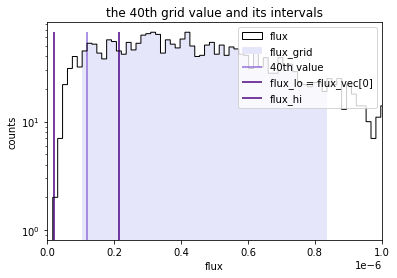

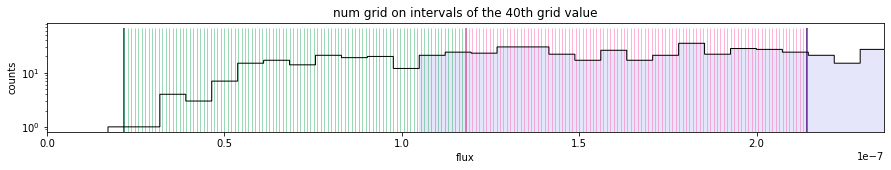

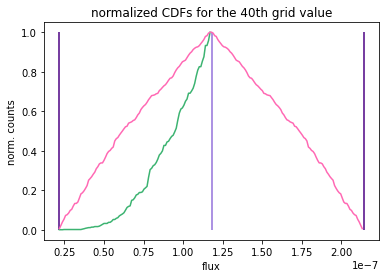

In [12]:
# for example the nth grid value:
n = 40
flux_val = flux_grid[n] 
dt_low = flux_val - flux_vec[0]
flux_high = flux_val + dt_low
flux_lo_vec = np.linspace(flux_vec[0], flux_val, num_bins)
flux_hi_vec = np.linspace(flux_val, flux_high, num_bins)

cdf_lo_norm, cdf_hi_norm, cdf_hi_r_norm, x_lo, x_hi = compute_cdf(flux_grid, n, flux_vec, weight_vec, num_bins)

plt.figure(0)
plt.title(f'the {n}th grid value and its intervals')
plot_hist_selected(flux_vec, flux_grid, 50)
plt.vlines(flux_val, ymin=min(c), ymax=max(c), color='mediumpurple', label=f'{n}th value')
plt.vlines(flux_vec[0], ymin=min(c), ymax=max(c), color='indigo', label='flux_lo = flux_vec[0]')
plt.vlines(flux_high, ymin=min(c), ymax=max(c), color='indigo', label='flux_hi')
plt.legend()
plt.xlabel('flux')
plt.ylabel('counts')
        
plt.figure(1,(15,2))
plt.title(f'num grid on intervals of the {n}th grid value')
plot_hist_selected(flux_vec, flux_grid, 100)
plt.vlines(flux_val, ymin=min(c), ymax=max(c), color='mediumpurple', label=f'{n}th value')
plt.vlines(flux_vec[0], ymin=min(c), ymax=max(c), color='indigo', label='flux_lo = flux_vec[0]')
plt.vlines(flux_high, ymin=min(c), ymax=max(c), color='indigo', label='flux_hi')
plt.vlines(flux_lo_vec, ymin=min(c), ymax=max(c), linewidth=0.5, color='mediumseagreen')
plt.vlines(flux_lo_vec[0], ymin=min(c), ymax=max(c), linewidth=0.5, color='mediumseagreen', label='flux_lo_vec = CDF bins')
plt.vlines(flux_hi_vec, ymin=min(c), ymax=max(c), linewidth=0.5, color='hotpink')
plt.vlines(flux_hi_vec[0], ymin=min(c), ymax=max(c), linewidth=0.5, color='hotpink', label='flux_lo_vec = CDF bins')
plt.xlim(0, flux_high + flux_vec[0])
plt.xlabel('flux')
plt.ylabel('counts')

plt.figure(2)
plt.title(f'normalized CDFs for the {n}th grid value')
plt.plot(flux_lo_vec[:-1], cdf_lo_norm, color='mediumseagreen', label='cdf_lo')
plt.plot(flux_hi_vec[:-1], cdf_hi_norm, color='hotpink', label='cdf_hi')
plt.plot(flux_lo_vec[:-1], cdf_hi_r_norm, color='hotpink', label='cdf_hi_r')
plt.vlines(flux_val, ymin=0, ymax=1, color='mediumpurple', label=f'{n}th value')
plt.vlines(flux_vec[0], ymin=0, ymax=1, color='indigo', label='flux_lo = flux_vec[0]')
plt.vlines(flux_high, ymin=0, ymax=1, color='indigo', label='flux_hi')
plt.xlabel('flux')
plt.ylabel('norm. counts')


### 4. quantify similarity of cdfs for each grid value

In [13]:
# ------ Set Parameters ------
stat = 'wolpert_jeff'
# statistic used to optimize test. Options are
# 'ks' : komlogorov smirnov test, 
# 'sumsq': sum of squared differences (Jeff's matlab code)
# 'sumsqpy': a python version of Jeff's matlab code
# 'wolpert_jeff'
# ----------------------------

In [14]:
def pks(z):
    """Compute KS distribution, see numerical recipes Eq. 6.14.56/57"""
    if z < 0.:
        raise ValueError("bad z in KSdist")
    if z == 0.:
        return 0.;
    if z < 1.18:
        y = np.exp(-1.23370055013616983/(z * z))
        return 2.25675833419102515*np.sqrt(-np.log(y)) \
                    *(y + np.power(y,9) + np.power(y,25) + np.power(y,49))
    else:
        x = np.exp(-2.*z*z)
        return 1. - 2.*(x - np.power(x,4) + np.power(x,9));
    
    
def qks(z):
    """Compute complemement of KS distribution, see numerical recipes Eq. 6.14.56/57"""
    if z < 0.:
        raise ValueError("bad z in KSdist")
    if z == 0.:
        return 1.
    if z < 1.18: 
        return 1.-pks(z);
    x = np.exp(-2.*z*z)
    return 2.*(x - np.power(x,4) + np.power(x,9))


def wolpert(h1, h2, axis = 0):
    """
    Calculate the ratio of posteriors using the algorithm of Wolpert (1995), 
    see his Eq. (11)
    Parameters
    ----------
    h1: array-like
        first histogram of data 
    h2: array-like
        second histogram of data 
    axis: int or None (optional) 
        Used when stack of histograms is provided as 2d array.
        In this case, axis specifies the axis of the histograms
        (vs the axis of the different cases). Default: 0
    Returns 
    -------
    log10 of posterior ratio of Pr(same) / Pr(different)
    """
    if not np.all(np.equal(h1.shape, h2.shape)):
        raise ValueError("Histrogams must have same shape!")
    n1 = h1.sum(axis = axis)
    n2 = h2.sum(axis = axis)
    num_bins = h1.shape[axis]
    # log of eq (10) divided by first factor of eq. (9) 
    # [gammaln is ln of the gamma function;
    #  remember n! = gamma( n + 1) ]
    log_common = gammaln(n1 + num_bins) + gammaln(n2 + num_bins) -\
        gammaln(num_bins) - gammaln(n1 + n2 + num_bins) 
    # log of second factor in eq. (9)
    log_hist = gammaln(h1 + h2 + 1) - gammaln(h1 + 1) - gammaln(h2 + 1) 
    # Combine and convert to base-10 log
    log_odds_ratio = np.log10(np.exp(1.)) * (log_common + np.sum(log_hist, axis = axis))
    return log_odds_ratio

In [15]:
flux_asym = np.ones_like(flux_grid) * np.nan
# measure of asymmetry of both intervals

for f_indx in range(flux_grid.size):
        flux_val = flux_grid[f_indx] 
        dt_low = flux_val - flux_vec[0]
        flux_high = flux_val + dt_low 

        flux_lo_vec = np.linspace(flux_vec[0], flux_val, num_bins)
        flux_hi_vec = np.linspace(flux_val, flux_high, num_bins)

        # compute CDF on both sides
        if stat == 'sumsq' or stat == 'wolpert_jeff':
            cdf_hi = np.zeros(flux_hi_vec.size - 1)
            cdf_lo = np.zeros(flux_lo_vec.size - 1)

            #check for every bin how many flux values there are whithin interval "outside" of bins and create CDF (based on weights!)
            for ii_bin in range(num_bins - 1):
                id_lo = flux_vec <= flux_lo_vec[ii_bin]
                id_hi = (flux_vec >= flux_hi_vec[ii_bin]) & \
                        (flux_vec <= flux_high)
                cdf_hi[ii_bin] = np.sum(weight_vec[id_hi])
                cdf_lo[ii_bin] = np.sum(weight_vec[id_lo])
            cdf_hi = cdf_hi[::-1] # reverse the high cdf

            if stat == 'sumsq': #normieren
                cdf_hi /= cdf_hi[-1]
                cdf_lo /= cdf_lo[-1]
                flux_asym[f_indx] = np.sum((cdf_hi - cdf_lo) ** 2.)
            else:
                flux_asym[f_indx] = -1. * wolpert(cdf_lo / cdf_lo.sum(), cdf_hi / cdf_hi.sum()) 

        else:
            idlo = flux_vec < flux_val
            idhi= (flux_vec >= flux_val) & (flux_vec <= flux_high)

            cdf_lo = np.concatenate([[0.],np.cumsum(weight_vec[idlo])])
            cdf_hi = np.concatenate([[0.],np.cumsum(weight_vec[idhi][::-1])])

            cdf_lo /= cdf_lo[-1]
            cdf_hi /= cdf_hi[-1]

            # convert fluxes below and above peak to array between 0 and 1
            xlo = np.concatenate([[0.],(flux_vec[idlo] - flux_vec[idlo][0])/ dt_low])
            xhi = (1. - (flux_vec[idhi] - flux_vec[idhi][0])/ dt_low)[::-1]
            xhi = np.concatenate([[0.],xhi])

            x = np.linspace(0.,1.,num_bins)
            # get the bin number where of fine sampled x array 
            bins_hi = np.digitize(x = x, bins = xhi) - 1
            bins_lo = np.digitize(x = x, bins = xlo) - 1
            if stat == 'sumsqpy':
                flux_asym[f_indx] = np.sum((cdf_hi[bins_hi] - cdf_lo[bins_lo])**2.)

            elif stat == 'ks':
                d = np.max(np.abs(cdf_hi[bins_hi] - cdf_lo[bins_lo]))
                ne = idhi.sum()* idlo.sum() / (idhi.sum() + idlo.sum())
                flux_asym[f_indx] = qks((np.sqrt(ne) + 0.12 + 0.11 / np.sqrt(ne))*d)

            elif stat == 'wolpert':
                # use wolpert algorithm with CDF normalized to integral
                chi = cdf_hi[bins_hi] * cdf_hi[-1] / cdf_hi[bins_hi].sum()
                clo = cdf_lo[bins_lo]* cdf_lo[-1] / cdf_lo[bins_lo].sum()
                flux_asym[f_indx] = -1. * wolpert(clo,chi)

          

### 5. determine QB
flux_val = best grid value (CDFs most similar)<br>
flux_quiet = all observed flux values in intervals of best value <br>
QB = mean or median of those flux values

Text(0, 0.5, 'counts')

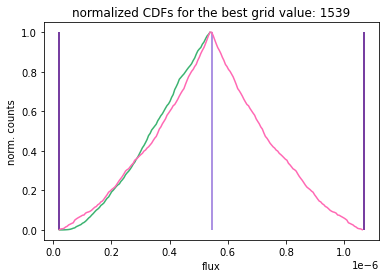

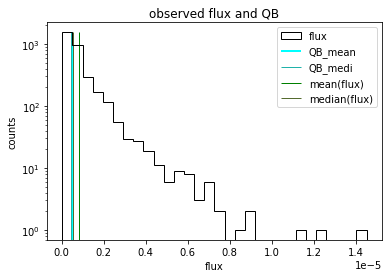

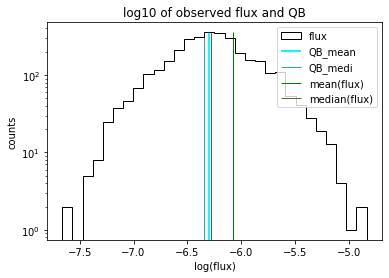

In [21]:
if stat == 'ks':
    id_best = np.argmax(flux_asym[np.isfinite(flux_asym)])
else:
    id_best = np.argmin(flux_asym[np.isfinite(flux_asym)])
flux_val = flux_grid[np.isfinite(flux_asym)][id_best]
final_limit = flux_val + dt_low
flux_quiet = flux_vec[flux_vec <= final_limit]
QB_mean = np.mean(flux_quiet)
QB_medi = np.median(flux_quiet)


cdf_lo_norm, cdf_hi_norm, cdf_hi_r_norm, x_lo, x_hi = compute_cdf(flux_grid, id_best, flux_vec, weight_vec, num_bins)


plt.figure(0)
plt.title(f'normalized CDFs for the best grid value: {id_best}')
plt.plot(x_lo, cdf_lo_norm, color='mediumseagreen', label='cdf_lo')
plt.plot(x_hi, cdf_hi_norm, color='hotpink', label='cdf_hi')
plt.plot(x_lo, cdf_hi_r_norm, color='hotpink', label='cdf_hi_r')
plt.vlines(flux_grid[id_best], ymin=0, ymax=1, color='mediumpurple', label=f'{n}th value')
plt.vlines(flux_vec[0], ymin=0, ymax=1, color='indigo', label='flux_lo = flux_vec[0]')
plt.vlines((flux_grid[id_best] - (flux_vec[0] - flux_grid[id_best])), ymin=0, ymax=1, color='indigo', label='flux_hi')
plt.xlabel('flux')
plt.ylabel('norm. counts')

plt.figure(1)
plt.title('observed flux and QB')
c,v,p = plt.hist(flux_vec, bins=30, log=True, histtype= 'step', color='k', label='flux')
plt.vlines(QB_mean, ymin=min(c), ymax=max(c), linewidth=2, color='cyan', label='QB_mean')
plt.vlines(QB_medi, ymin=min(c), ymax=max(c), linewidth=1, color='lightseagreen', label='QB_medi')
plt.vlines(np.mean(flux), ymin=min(c), ymax=max(c), linewidth=1, color='green', label='mean(flux)')
plt.vlines(np.median(flux), ymin=min(c), ymax=max(c), linewidth=1, color='darkolivegreen', label='median(flux)')


plt.legend()
plt.xlabel('flux')
plt.ylabel('counts')

plt.figure(2)
plt.title('log10 of observed flux and QB')
c,v,p = plt.hist(np.log10(flux_vec), bins=30, log=True, histtype= 'step', color='k', label='flux')
plt.vlines(np.log10(QB_mean), ymin=min(c), ymax=max(c), linewidth=2, color='cyan', label='QB_mean')
plt.vlines(np.log10(QB_medi), ymin=min(c), ymax=max(c), linewidth=1, color='lightseagreen', label='QB_medi')
plt.vlines(np.log10(np.mean(flux)), ymin=min(c), ymax=max(c), linewidth=1, color='green', label='mean(flux)')
plt.vlines(np.log10(np.median(flux)), ymin=min(c), ymax=max(c), linewidth=1, color='darkolivegreen', label='median(flux)')
plt.legend()
plt.xlabel('log(flux)')
plt.ylabel('counts')